In [1]:
# !pip install diffusers

In [2]:
import torch
from datasets import load_dataset
import torchvision.transforms.functional as TF
from lib import *
from diffusers import UNet2DModel

/home/marconobile/miniconda3/envs/fastai_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/marconobile/miniconda3/envs/fastai_venv/lib/python3.10/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/marconobile/miniconda3/envs/fastai_venv/lib/python3.10/site-packages/torch/cuda/__init__.py:740: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


(torch.Size([32, 3, 32, 32]), tensor([0, 6, 0, 2, 7, 2, 1, 2, 4, 1]))

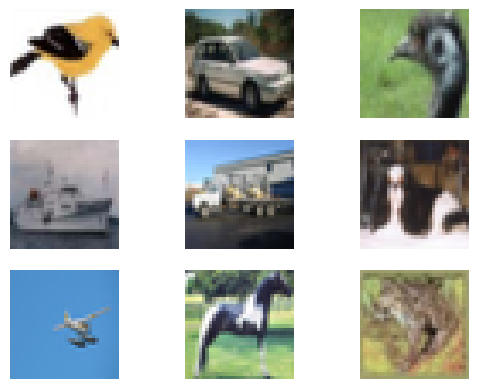

In [3]:
x,y = 'img','label'
dsd = load_dataset("cifar10")

@inplace
def transformi(b): b[x] = [TF.to_tensor(o)-.5 for o in b[x]]

set_seed(42)
device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_datasetDict(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
showImgGroup(xb[-9:]+.5, grid=(3,3))
xb.shape,yb[:10]


In [4]:
from types import SimpleNamespace
# SimpleNamespace just returns a anonymous class that contains tthe data passed as input args as dmembers
def linear_sched(betamin=0.0001, betamax=0.02, n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(0), sigma=beta.sqrt())

In [5]:
n_steps = 1000
lin_abar = linear_sched(betamax=.1)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sigma

In [6]:
def noisify(x0, alpha_hat):
    device = x0.device
    n = len(x0) # batch size
    t = torch.randint(0, n_steps, (n,), dtype=torch.long) # for each obs in batch create a timestep that defines how much to perturbate that img
    epsilon = torch.randn(x0.shape, device=device) # create wn noise ~N(0,1)
    alpha_hat_t = alpha_hat[t].reshape(-1, 1, 1, 1).to(device)  
    xt = alpha_hat_t.sqrt() * x0 + (1-alpha_hat_t).sqrt()*epsilon
    return (xt, t.to(device)), epsilon

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


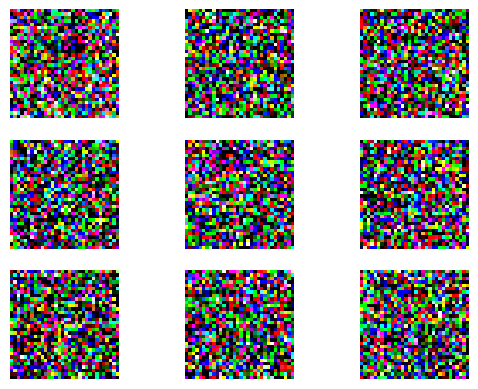

In [7]:
(xt, t), eps = noisify(xb, alphabar)
showImgGroup(xt[-9:], grid=(3,3))

In [17]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [18]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers):
                torch.nn.init.orthogonal_(p.conv.weight)
    
    for o in model.up_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [19]:
def collate_ddpm(b): return noisify(default_collate(b)[x], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm)

In [20]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [21]:
# the model that we were using for minst
model = UNet(in_channels=1, out_channels=1, 
             block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
sum(p.numel() for p in model.parameters())

15890753

In [22]:
# the model that we use now for cifar (the default model)
model = UNet(in_channels=3, out_channels=3)
sum(p.numel() for p in model.parameters())

274056163

In [30]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn):
        self.scaler = torch.cuda.amp.GradScaler()
        
    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()
        
    def after_loss(self, learn):
        self.autocast.__exit__(None,None,None)
        
    def backward(self, learn):
        self.scaler.scale(learn.loss).backward()
        
    def step(self, learn):
        # as required in docs: 
        # https://pytorch.org/docs/stable/notes/amp_examples.html
        self.scaler.step(learn.opt)
        self.scaler.update()

# the idea is that pytorch implements mixed precision with a context 
# manager: 
# with autocast(device_type='cuda', dtype=torch.float16):
# we call the .__enter__() of that contex manager manually

In [31]:
from torch.optim.lr_scheduler import OneCycleLR

lr = 1e-3
epochs = 1
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(partial(OneCycleLR, max_lr=lr, total_steps=tmax))
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricCB(), BatchSchedCB(sched)]
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [32]:
learn.fit(epochs)

KeyboardInterrupt: 

In [ ]:
@torch.no_grad()
def sample(model, size):
    device = next(model.parameters()).device
    x_t = torch.randn(size).to(device)
    preds = []
    for t in reversed(n_steps):
        t_batch = torch.full((x_t.shape[0], ), t, device=device, dtype=torch.long)
        z = ((torch.randn(x_t.shape)) if t>0 else torch.zeros(x_t.shape)).to(device)
        prev_alpha_bar_t = alphabar[t-1] if t>0 else torch.tensor(1)
        beta_bar_t = 1. - alphabar[t]
        prev_beta_bar_t = 1. - prev_alpha_bar_t
        noise = model((x_t, t_batch)) 
        x_0_hat = ((x_t - beta_bar_t.sqrt() * noise)) / alphabar[t].sqrt()
        x_t = x_0_hat * prev_alpha_bar_t * (1.-alpha[t]) / beta_bar_t *alpha[t].sqrt() * prev_beta_bar_t/beta_bar_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds 

In [ ]:
%%time
samples = sample(model, (bs, 3,32,32))

In [ ]:
s = (samples[-1], +.5).clamp()
showImgGroup(s[-9:], grid=(3,3))

# Weights and Biases code

In [ ]:
import wandb

class WandBCB(MetricCB):
    order = 100
    def __init__(self, config, *ms, project="ddpm_cifar10", **metrics):
        fc.store_attr()
        super().__init__()

    def before_fit(self, learn): wandb.init(project = self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d):
        if self.train:
            wandb.log({'train_' + m: float(d[m]) for m in self.all_metrics})
        else:
            wandb.log({'val_'+ m: float(d[m]) for m in self.all_metrics})
            wandb.log({'samples': self.sample_figure(learn)})
        print(d)

    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model (16, 3, 32, 32))
        s = (samples[-1], +.5).clamp(0, 1)
        plt.clf()
        return showImgGroup(s[-9:], grid=(3,3))        

    def after_batch(self, learn):        
        super().after_batch(learn)
        wandb.log({'loss':learn.loss})
    
    

        

In [ ]:
{'asd_' + str(i): i for i in range(3)}

{'asd_0': 0, 'asd_1': 1, 'asd_2': 2}

In [ ]:
tuple([i for i in range(5)])

(0, 1, 2, 3, 4)